In [2]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore") 
# CUSTOMARY IMPORTS
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# TRAINING HYPERPARAMETERS: 
n_epochs = 5           # How many passes through the training data  
batch_size = 64  # Training batch size usually in [1,256]

learning_rate = 0.01   # Learning rate for optimizer like SGD usually in [0.001, 0.1]

random_seed = 1  

torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
import torchvision
from torchvision import transforms
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.CIFAR10(root = './datasets/',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                #   transforms.Normalize(mean = (0.1307,), std = (0.3081,))
                                                  ]),
                                           download = True)


test_dataset = torchvision.datasets.CIFAR10(root = './datasets/',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                #   transforms.Normalize(mean = (0.1325,), std = (0.3105,))
                                                  ]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)



Files already downloaded and verified
Files already downloaded and verified


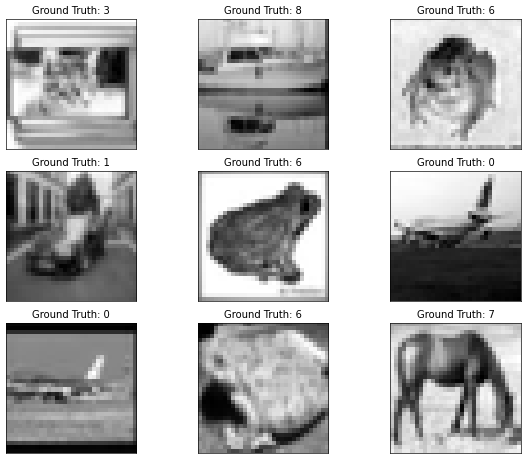

In [29]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(test_loader)
batch_idx, (example_X, example_y) = next(examples)
# next means the next batch of data, which is the first batch of data in this case

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_X[i][0], cmap='gray')
  plt.title("Ground Truth: {}".format(example_y[i]))
  plt.xticks([]) # remove x-axis ticks, which are the pixel numbers
  plt.yticks([])

In [30]:
import warnings
warnings.filterwarnings("ignore") 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 6,kernel_size = 5,stride = 1,padding = 0)
        self.conv2 = nn.Conv2d(in_channels = 6,out_channels = 16,kernel_size = 5,stride = 1,padding = 0)
        
        self.fc1 = nn.Linear(in_features = 5 * 5 * 16,out_features = 120)
        self.fc2 = nn.Linear(in_features = 120,out_features = 84)
        self.fc3 = nn.Linear(in_features = 84,out_features = 10)           # number of classes/digits = 10

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size = 2,stride = 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size = 2,stride = 2)
        
        x = x.reshape(x.size(0), -1)     # reshape

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, training=self.training)  # Apply dropout only during training
        x = self.fc3(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [31]:
import warnings
warnings.filterwarnings("ignore") 

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Layer 1  which has six kernels of size 5x5 with padding 0 and stride 1    
        # input (1, 28, 28) padding to(1,32,32) 
        # output(6, 28, 28)   
        self.conv_pool1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5, 5),padding=0),  
            #nn.BatchNorm2d(6),       
            nn.ReLU(),                     
            nn.MaxPool2d(2, stride=2)                 # output(6, 14, 14)
        )
       

        self.conv_pool2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),  # output(16, 10, 10)
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # output(16, 5, 5)
        
        # the fully connected layer
        self.fc1 = nn.Sequential(                  
            nn.Linear(16*5*5, 120),
            nn.ReLU()
        )

     
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        # the output layer
        self.out = nn.Sequential(
            nn.Linear(84, 10),

        )

    # 前向传播
    def forward(self, x):

        x = self.conv_pool1(x)
        x = self.conv_pool2(x)
        x = x.view(x.size(0), -1)       # resize to 2-dims(batch_size, 16*5*5) 展平成1维
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv_pool1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [32]:
params = list(net.parameters())
print(len(params)) # contains weights and bias
print(params[0].size()) # conv1's weight
print(params[1].size()) # conv1's bias

10
torch.Size([6, 3, 5, 5])
torch.Size([6])


In [34]:
test = torch.randn((1, 1, 32, 32)).to(device)
test = torch.cat([test] * 3, dim=1)
pred = net(test) # forward
print(pred)

tensor([[ 0.0178, -0.0483,  0.0109,  0.0051, -0.0450,  0.0586, -0.0750,  0.1523,
          0.1241,  0.0604]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [35]:
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters())
#optimizer = optim.Adam(net.parameters(), lr=0.003)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

In [36]:
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1, n_epochs + 1):
    #构建tqdm进度条
    processBar = tqdm(train_loader,unit = 'step')
    #打开网络的训练模式
    net.train(True)
    #开始对训练集的DataLoader进行迭代
    totalTrainLoss = 0.0
   
    for step,(trainImgs,labels) in enumerate(processBar):
        
        #将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
        
        #清空模型的梯度
        optimizer.zero_grad()
        
        #对模型进行前向推理
        outputs = net(trainImgs)
        
        #计算本轮推理的Loss值
        loss = criterion(outputs,labels)
        #计算本轮推理的准确率
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        
        #进行反向传播求出模型参数的梯度
        loss.backward()
        #使用迭代器更新模型权重
        optimizer.step()

        #将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                    (epoch,n_epochs,loss.item(),accuracy.item()))

        totalTrainLoss+= loss
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            totalSize = 0
            net.train(False)
            for testImgs,labels in test_loader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = criterion(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                totalSize += labels.size(0)
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/totalSize
            testLoss = totalLoss/len(test_loader)
            trainLoss = totalTrainLoss/len(train_loader)
            history['Train Loss'].append(trainLoss.item())
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,n_epochs,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()

[1/5] Loss: 2.2272, Acc: 0.5000, Test Loss: 2.0756, Test Acc: 0.2606: 100%|██████████| 782/782 [00:18<00:00, 43.00step/s]
[2/5] Loss: 1.8810, Acc: 0.3125, Test Loss: 1.7638, Test Acc: 0.3632: 100%|██████████| 782/782 [00:17<00:00, 43.72step/s]
[3/5] Loss: 1.5097, Acc: 0.3125, Test Loss: 1.5621, Test Acc: 0.4193: 100%|██████████| 782/782 [00:17<00:00, 44.41step/s]
[4/5] Loss: 1.5264, Acc: 0.4375, Test Loss: 1.5448, Test Acc: 0.4499: 100%|██████████| 782/782 [00:17<00:00, 43.66step/s]
[5/5] Loss: 1.5474, Acc: 0.5000, Test Loss: 1.4133, Test Acc: 0.4851: 100%|██████████| 782/782 [00:17<00:00, 44.03step/s]


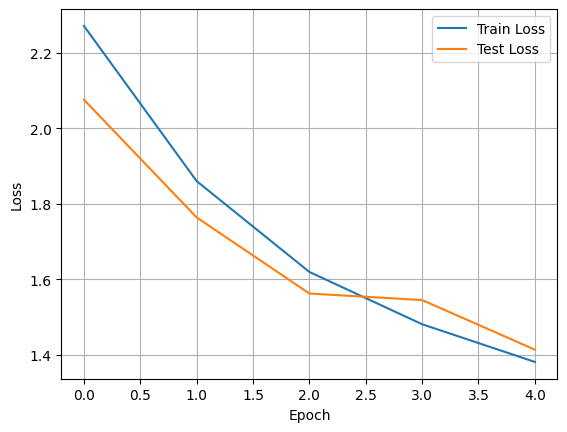

In [37]:
#fig=plt.figure(figsize=(10, 8), dpi=60)
#对测试Loss进行可视化
plt.plot(history['Train Loss'],label = 'Train Loss')
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

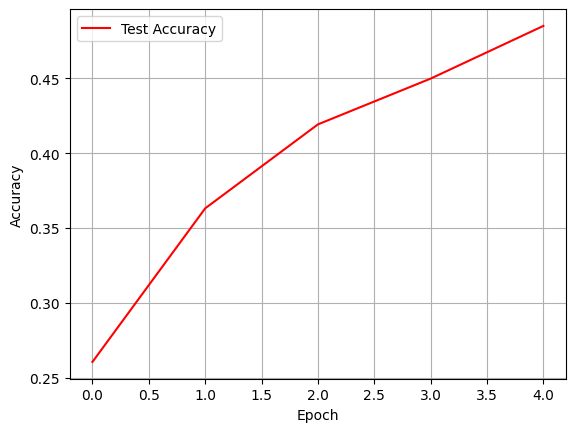

In [38]:
#对测试准确率进行可视化
plt.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [39]:
torch.save(net.state_dict(),'./models/mnist.pth')

RuntimeError: Parent directory ./models does not exist.

In [ ]:
model = Net()
model.load_state_dict(torch.load('./models/mnist.pth'))
model.eval()

In [ ]:
torch.save(model, './models/mnist2.pth')

In [ ]:
# Model class must be defined somewhere
model = Net()
model = torch.load('./models/mnist2.pth')
model.eval()


In [ ]:
dataiter = iter(test_loader)
images,labels = next(dataiter)

outputs  = model(images)
fig=plt.figure(figsize=(10, 8), dpi=60)
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray')
  plt.title("Prediction: {}".format(
    outputs.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])